#### Environment used: kmembert_env

In [1]:
#!python -m spacy download fr_core_news_sm
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [15]:
import numpy as np
import os
import argparse
from time import time
from collections import defaultdict
import matplotlib.pyplot as plt
import re

import torch
from torch.utils.data import DataLoader

from KmemBERT.kmembert.dataset import EHRDataset
from KmemBERT.kmembert.utils import pretty_time, printc, create_session, save_json, get_label_threshold, get_error
from KmemBERT.kmembert.models import HealthBERT
from KmemBERT.kmembert.testing import test

from KmemBERT.kmembert.preprocesser import EHRPreprocesser
from KmemBERT.kmembert.utils import get_label, time_survival_to_label, printc
from KmemBERT.kmembert.preprocessing.correction import *

In [3]:
parser = argparse.ArgumentParser()
parser.add_argument("-d", "--data_folder", type=str, default="ehr", 
    help="data folder name")
parser.add_argument("-dict", "--dict_name", type=str, default="fr-100k.txt", 
    help="french dict path. Please use the default one except if you know what you are doing")
parser.add_argument("-dist", "--distance", type=int, default=2, 
    help="distance parameter")
parser.add_argument("-mtl", "--min_token_length", type=int, default=5, 
    help="min token length to be corrected")

args = parser.parse_args("")

In [4]:
from collections import Counter
# Read dataframes
path_alive = "C:\\Users\\DIPIAZZA\\Documents\\CLB Projet\\Data\\CLB\\6_dossiers\\alive_small.json"
path_dead = "C:\\Users\\DIPIAZZA\\Documents\\CLB Projet\\Data\\CLB\\6_dossiers\\dead_small.json"

df_alive = pd.read_json(path_alive)
df_dead = pd.read_json(path_dead)

# Add Flag_dead : 1 if dead, 0 otherwise
df_alive['FLAG_dead'] = 0
df_dead['FLAG_dead'] = 1

# Concatenated dataframe
df = pd.concat([df_alive, df_dead])
df.head()

NameError: name 'pd' is not defined

#### Liste des expressions (str) à supprimer (inutiles dans la modelisation)

In [5]:
from spacy.lang.fr.stop_words import STOP_WORDS as fr_stop
import re

def clean_step(data: pd.DataFrame, text_name: str):
    """
    df: pd.DataFrame: indicates which dataframe to clean
    text_name: str: name of the column which contains text
    This function permits to add a column to the df with cleaned and pre-process text
    """
    # Initialize TextCorrector Object (correction.py)
    nlp = spacy.load('fr_core_news_sm')
    corrector = get_corrector(args)
    text_corrector = TextCorrector(nlp, corrector, min_token_length=args.min_token_length)
    text_corrector.reset()

    # Suppression des XXXXX (anonymisation) par patientnom
    data["newText"] = data[text_name].apply(lambda x: re.sub("XXXXXX\S*", '[nom]', x))

    # Utilisation du correction
    data["newText"] = data["newText"].progress_apply(text_corrector)

    # Partie consacree au cleaning + suppression des infos non desirees
    data["newText"] = data["newText"]

    # Suppression de certains mots pas utiles
    part_to_remove = ["Compte-rendu de consultation", "Email", "mail", "Tél.", "Fax", "Emsll", "Emsil"]
    for to_remove in part_to_remove:
        data["newText"] = data["newText"].apply(lambda x: re.sub(to_remove, '', x))

    # Suppresion des adresses mails
    data["newText"] = data["newText"].apply(lambda x: re.sub("\S*@\S*\s", '', x))

    # Suppression des sites internets
    data["newText"] = data["newText"].apply(lambda x: re.sub("\S*.fr", '', x))

    # Suppression de certaines chaines de characteres inutiles
    data["newText"] = data["newText"].apply(lambda x: re.sub("\S* :", '', x))

    # Suppression des numeros de telephone
    data["newText"] = data["newText"].apply(lambda x: re.sub(" \d+", " ", x))

    # Suppression des stop-words
    fr_stop_list_space = [' {0} '.format(elem) for elem in list(fr_stop)]
    for to_remove in fr_stop_list_space:
        data["newText"] = data["newText"].apply(lambda x: re.sub(to_remove, ' ', x))

    return data

In [6]:
clean_step(df, "Text")

100%|██████████| 166/166 [00:13<00:00, 12.53it/s]


,AnonymizedIpp,SourceTitle,Text,FLAG_dead,newText
0,67988a7aeaf96959fe35ee1633ddba37f27543b1a40a89...,Compte-rendu de consultation,Compte-rendu de consultation ContenuAvis de co...,0,continuais comite avis thÃ©rapeutique. Jetaie...
1,67988a7aeaf96959fe35ee1633ddba37f27543b1a40a89...,Compte-rendu de consultation,Compte-rendu de consultation ContenuPatiente v...,0,contenupatiente vue ambulatoire traitement. L...
2,67988a7aeaf96959fe35ee1633ddba37f27543b1a40a89...,Compte-rendu de consultation,Compte-rendu de consultation ContenuPatiente v...,0,contenupatiente vue ambulatoire traitement. L...
3,67988a7aeaf96959fe35ee1633ddba37f27543b1a40a89...,Compte-rendu de consultation,Compte-rendu de consultation ContenuPatiente v...,0,contenupatiente vue ambulatoire visite survei...
4,67988a7aeaf96959fe35ee1633ddba37f27543b1a40a89...,Compte-rendu de consultation,Compte-rendu de consultation ContenuPatiente v...,0,contenupatiente vue ambulatoire visite survei...
...,...,...,...,...,...
61,7787b59e5fb123a481c094bbecbda9b3ac15bf52810dc7...,Compte-rendu de consultation,Compte-rendu de consultation Contenu15Gy.,1,contenu15gy.
62,7787b59e5fb123a481c094bbecbda9b3ac15bf52810dc7...,Compte-rendu de consultation,Compte-rendu de consultation Contenu21Gy.,1,contenu21gy.
63,7787b59e5fb123a481c094bbecbda9b3ac15bf52810dc7...,Compte-rendu de consultation,Compte-rendu de consultationva bien . Le cou e...,1,. Le cou souple
64,7787b59e5fb123a481c094bbecbda9b3ac15bf52810dc7...,Compte-rendu de consultation,Compte-rendu de consultation Contenu36 GY. Va ...,1,contenu gy. Va bien.


#### Nombre de mots par séquence

In [7]:
df['nb_words'] = df['Text'].apply(lambda x: len(x.split()))

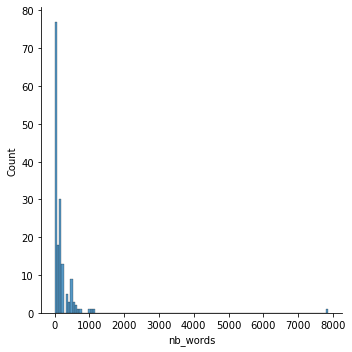

In [8]:
import seaborn as sns
sns.displot(df, x="nb_words")

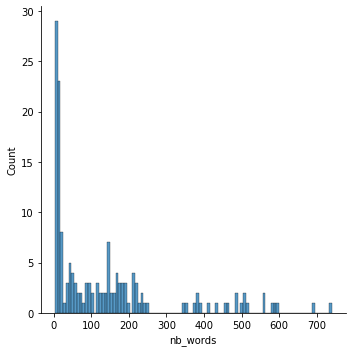

In [9]:
df = df.drop(df[df.nb_words > 1000].index)

sns.displot(df, x="nb_words", bins=100)

In [10]:
for i in df[(df.nb_words > 600) & (df.nb_words < 700)]["Text"]:
    print(i, "\n")

Compte-rendu de consultation ContenuPatiente vue lors d'une hospitalisation pour un suivi de traitement. Karnofsky = 60 %, PS = 2, Poids actuel = 85,0 kg, Indice masse corporelle = 29,41 kg/m².   Diagnostic : Carcinome ovarien type séreux de haut grade, actuellement en rechute métastatique péritonéal. Variant inconnu de BRCA2. Motif : Suivi après 6 cures dans le protocole BOLD ( C1J1 24/07/19)   Histoire de la maladie : - 2017 : Découverte stade IV pleural initial, chimiothérapie CARBO TAXOL première puis Cytoréduction CC0-CC1 avec omentectomie - péritonectomie douglassectomie étendue + curage pelvien en Juin 2017. 2 cures post-opératoires de CARBO TAXOL puis entretien par AVASTIN puis arrêt. CA125 11000 initial normalisé. - Octobre 2018 : Rechute platino-Sensible (+15mois) marqueur CA125 à 40 et TEP + centro pelvien traitée par CARBO-GEMZAR (pas de compte-rendu, CARBO CAELYX recommandé en RCP ?), - mars 2019 : bonne réponse à la chimiothérapie, inclusion dans CHIPOR le 14/03/2019 : cy

In [11]:
len(df[(df.nb_words > 40) & (df.nb_words < 60)]['Text'])

9

In [1]:
# Isoler les individus avec un nombre de mots compris entre 40 et 400. 
df_filter = df[(df.nb_words >= 40) & (df.nb_words <= 400)]

print("Shape of the df before filtered:", df.shape)
print("Shape of the df after filtered:", df_filter.shape)
df_filter

NameError: name 'df' is not defined

In [14]:
df_filter.to_csv("C:\\Users\\DIPIAZZA\\Documents\\CLB Projet\\Data\\CLB\\6_dossiers\\df_filter.csv", index=False)